In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import cv2
import os

import copy
import random
import time

In [2]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
path = '/home/mouli/Documents/pytorch/rice/Rice_Image_Dataset'

In [4]:
data_dir = pathlib.Path(path)
data_dir

PosixPath('/home/mouli/Documents/pytorch/rice/Rice_Image_Dataset')

In [5]:
arborio = list(data_dir.glob('Arborio/*'))[:600]
basmati = list(data_dir.glob('Basmati/*'))[:600]
ipsala = list(data_dir.glob('Ipsala/*'))[:600]
jasmine = list(data_dir.glob('Jasmine/*'))[:600]
karacadag = list(data_dir.glob('Karacadag/*'))[:600]

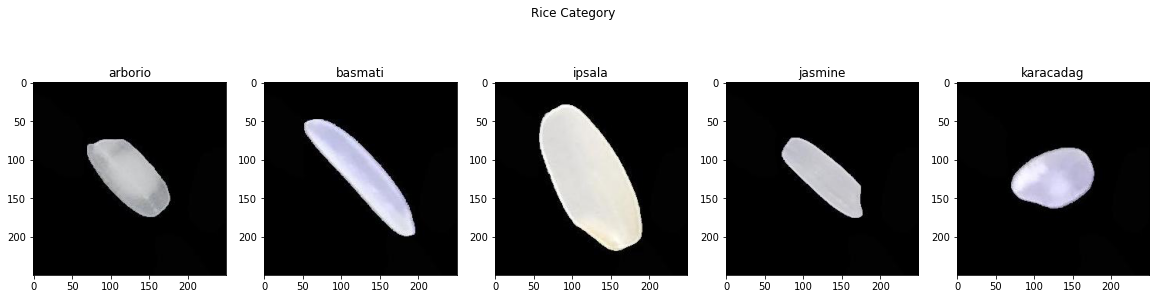

In [6]:
import matplotlib.image as img
fig, ax = plt.subplots(ncols = 5, figsize = (20,5))
fig.suptitle('Rice Category')
arborio_image = img.imread(arborio[0])
basmati_image = img.imread(basmati[0])
ipsala_image = img.imread(ipsala[0])
jasmine_image = img.imread(jasmine[0])
karacadag_image = img.imread(karacadag[0])

ax[0].set_title('arborio')
ax[1].set_title('basmati')
ax[2].set_title('ipsala')
ax[3].set_title('jasmine')
ax[4].set_title('karacadag')

ax[0].imshow(arborio_image)
ax[1].imshow(basmati_image)
ax[2].imshow(ipsala_image)
ax[3].imshow(jasmine_image)
ax[4].imshow(karacadag_image)

plt.show()

In [7]:
df_images = {
    'arborio' : arborio,
    'basmati' : basmati,
    'ipsala' : ipsala,
    'jasmine' : jasmine,
    'karacadag': karacadag
}

df_labels = {
    'Arborio' : 0,
    'Basmati' : 1,
    'Ipsala' : 2,
    'Jasmine' : 3,
    'Karacadag': 4
}
    

In [8]:
classes = {0: 'Arborio', 1: 'Basmati', 2: 'Ipsala', 3: 'Jasmine', 4: 'Karacadag'}

In [9]:
class_names = ['Karacadag', 'Basmati', 'Jasmine', 'Arborio', 'Ipsala']
num_class = len(class_names)

image_files = [[os.path.join(path, class_name, x) for x in os.listdir(os.path.join(path, class_name))] for class_name in class_names]

In [10]:
images_paths = []
for i in range(5):
    for j in range(len(image_files[i])):
        current = image_files[i]
        images_paths.append(current[j])

In [11]:
import random

random.shuffle(images_paths)

train_paths = images_paths[:60000]
test_paths = images_paths[60000:70000]
valid_paths = images_paths[70000:]

In [12]:
import torchvision.transforms as transforms

In [13]:
from PIL import Image
lol = Image.open('/home/mouli/Documents/pytorch/rice/Rice_Image_Dataset/Karacadag/Karacadag (13590).jpg')

print(lol.format)
print(lol.mode)
print(lol.size)

JPEG
RGB
(250, 250)


In [14]:
transformations = transforms.Compose(
    [
        transforms.Resize((256,256)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize((0.5),(0.5))
    ]
)


In [15]:
from torch.utils.data import Dataset
from random import randint

class ImageDataset(Dataset):
    def __init__(self, df_labels, base_dir, transform=None):
        super().__init__()
    
        self.base_dir = base_dir
        self.df_labels = df_labels
        self.transform = transform
        
    def __len__(self):
        return len(self.base_dir)
    
    def __getitem__(self, index):
        
        
        #img_dir_list = os.listdir(os.path.join(self.base_dir,self.img_labels[index]))
        #print((img_dir_list))

        image_path = self.base_dir[index]
        #image_path = os.path.join(self.base_dir)
        
        image = Image.open(image_path)
        
        label_name = image_path.split('/')[-2]
        
        label = self.df_labels[label_name]
        
        if self.transform is not None:
            image = self.transform(image)
        return (image, label)

In [16]:
train_data = ImageDataset(df_labels, train_paths, transformations)
test_data = ImageDataset(df_labels, test_paths, transformations)
valid_data = ImageDataset(df_labels, valid_paths, transformations)

In [18]:
from torch.utils.data import DataLoader
train_ds = DataLoader(train_data, batch_size = 64, shuffle = True)
val_ds = DataLoader(valid_data, batch_size = 64, shuffle = True)
test_ds = DataLoader(test_data, batch_size = 64, shuffle = True)

In [19]:
len(train_ds)

938

In [20]:
class LeNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=6,
                               kernel_size=5)

        self.conv2 = nn.Conv2d(in_channels=6,
                               out_channels=16,
                               kernel_size=5)

        self.fc_1 = nn.Linear(16 * 61 * 61, 120)
        self.fc_2 = nn.Linear(120, 84)
        self.fc_3 = nn.Linear(84, output_dim)

    def forward(self, x):

        # x = [batch size, 1, 28, 28]

        x = self.conv1(x)

        # x = [batch size, 6, 24, 24]

        x = F.max_pool2d(x, kernel_size=2)

        # x = [batch size, 6, 12, 12]

        x = F.relu(x)

        x = self.conv2(x)

        # x = [batch size, 16, 8, 8]

        x = F.max_pool2d(x, kernel_size=2)

        # x = [batch size, 16, 4, 4]

        x = F.relu(x)

        x = x.view(x.shape[0], -1)

        # x = [batch size, 16*4*4 = 256]

        h = x

        x = self.fc_1(x)

        # x = [batch size, 120]

        x = F.relu(x)

        x = self.fc_2(x)

        # x = batch size, 84]

        x = F.relu(x)

        x = self.fc_3(x)

        # x = [batch size, output dim]

        return x, h

In [21]:
OUTPUT_DIM = 5
model = LeNet(OUTPUT_DIM)

In [22]:
# from graphviz import Digraph
# from torchviz import make_dot

# #x=Variable(torch.randn(batch_size,1,2,num_samples))
# x = torch.randn(100, 3, 32, 32).requires_grad_(True)
# y = model(x)
# make_dot(y, params=dict(list(model.named_parameters())))

In [23]:
model

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc_1): Linear(in_features=59536, out_features=120, bias=True)
  (fc_2): Linear(in_features=120, out_features=84, bias=True)
  (fc_3): Linear(in_features=84, out_features=5, bias=True)
)

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [25]:
model = model.to(device)

In [26]:
from torch.optim import Adam 

In [27]:
optimizer = Adam(model.parameters(), lr = 0.0001)
loss_fun = F.cross_entropy

In [28]:
def train(model, epoch, train_ds):
    model.train()
    total_num = len(train_ds.dataset)
    train_loss = 0
    correct_num = 0

    for image, label in train_ds:
        image = image.to(device)
        label = label.to(device)
        # Convert the tag from int32 type to long type, otherwise the calculation loss will report an error
        label = label.to(torch.long)

        output,_ = model(image)
        loss = loss_fun(output, label)
        train_loss += loss.item() * label.size(0)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        predict = torch.argmax(output, dim=-1)
        correct_num += label.eq(predict).sum()

    train_loss = train_loss / total_num
    train_acc = correct_num / total_num
    print('epoch: {} --> train_loss: {:.6f} - train_acc: {:.6f} - '.format(
        epoch, train_loss, train_acc), end='')
    
    
def evaluate(model, eval_ds, mode='val'):
    model.eval()

    total_num = len(eval_ds.dataset)
    eval_loss = 0
    correct_num = 0

    for image, label in eval_ds:
        image = image.to(device)
        label = label.to(device)
        label = label.to(torch.long)
        
        output,_ = model(image)
        loss = loss_fun(output, label)
        eval_loss += loss.item() * label.size(0)

        predict = torch.argmax(output, dim=-1)
        correct_num += label.eq(predict).sum()
    
    eval_loss = eval_loss / total_num
    eval_acc = correct_num / total_num
    
    print('{}_loss: {:.6f} - {}_acc: {:.6f}'.format(
        mode, eval_loss, mode, eval_acc))

In [29]:
for epoch in range(5):
    train(model, epoch, train_ds)
    evaluate(model, val_ds)

epoch: 0 --> train_loss: 0.199764 - train_acc: 0.933117 - val_loss: 0.091109 - val_acc: 0.965800
epoch: 1 --> train_loss: 0.076263 - train_acc: 0.972833 - val_loss: 0.067905 - val_acc: 0.976800


KeyboardInterrupt: 

In [ ]:
evaluate(model, test_ds, mode='test')